In [1]:
import time
from typing import Dict, Union
import sys

import numpy as np
from PIL import Image
import Quartz
import Quartz.CoreGraphics as CG
from scipy.spatial.distance import euclidean
import torch
from typing_extensions import Literal


# https://github.com/ultralytics/yolov5/issues/353
sys.path.insert(0, '../02_train_detector/yolov5')

In [2]:
model = torch.hub.load(
    repo_or_dir='../02_train_detector/yolov5',
    model='custom',
    source='local',
    path='../runs/train/exp/weights/best.pt',
    device='mps',
)

YOLOv5 🚀 v7.0-71-gc442a2e Python-3.9.12 torch-1.13.0 MPS

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients
Adding AutoShape... 


In [3]:
WINDOW_TYPE_HINT = Dict[str, Union[int, float, bool, str, Dict[str, Union[int, str]]]]


def get_window(window_title: str = 'DeSmuME') -> WINDOW_TYPE_HINT:
    """
    Using the Python-port of Apple's Core Graphics Objective-C library, return the window that
    contains ``window_title`` in the window title. For example, the DS emulator I am using to run
    the game has the window title ``'DeSmuME'`` (hence the default here).

    Parameters
    ----------
    window_title: str
        Title of the Mac window to screenshot

    Returns
    -------
    window: dict (or an "Objective-C class __NSDictionaryI", to be specific)

    Raises
    ------
    ``ValueError`` if a window cannot be found with lowercase title substring ``window_title``.

    """
    for window in Quartz.CGWindowListCopyWindowInfo(
        Quartz.kCGWindowListOptionOnScreenOnly,
        Quartz.kCGNullWindowID,
    ):
        if window_title.lower() in window['kCGWindowOwnerName'].lower():
            return window

    raise ValueError(f'No window titled ``{window_title}`` was found :(')


def take_screenshot_of_window(window: WINDOW_TYPE_HINT) -> Image.Image:
    """
    Take a screenshot of window ``window`` and return the image as a ``PIL.Image`` object.

    Parameters
    ----------
    window: dict (or an "Objective-C class __NSDictionaryI", to be specific)
        Should be the output of the ``get_window`` function. This dictionary must at least contain
        keys ``kCGWindowBounds`` and ``kCGWindowOwnerPID``

    Returns
    -------
    image: PIL.Image.Image

    Notes
    -----
    If the window is not at the forefront of the screen, the returned image will not be as expected.
    Under the hood, this just takes a screenshot of the exact pixel range of the screen that a
    window is, so if the window is behind another window, then that window's contents will be
    screenshotted with the pixel range of the desired window's size. TL;DR - make sure the window is
    visible on your screen before calling this function.

    """
    region = CG.CGRectMake(
        window['kCGWindowBounds']['X'],
        window['kCGWindowBounds']['Y'],
        window['kCGWindowBounds']['Width'],
        window['kCGWindowBounds']['Height'],
    )

    # Create screenshot as CGImage
    cg_image = CG.CGWindowListCreateImage(
        region,
        CG.kCGWindowListOptionOnScreenOnly,
        window['kCGWindowOwnerPID'],
        CG.kCGWindowImageDefault,
    )

    image = Image.frombuffer(
        'RGBA',
        (CG.CGImageGetWidth(cg_image), CG.CGImageGetHeight(cg_image)),
        CG.CGDataProviderCopyData(CG.CGImageGetDataProvider(cg_image)),
        'raw',
        'BGRA',
        CG.CGImageGetBytesPerRow(cg_image),
        1,
    )

    return image


def get_character_to_search_for(
    image: Image.Image,
    distance_threshold: float = 100,
) -> Literal['luigi', 'mario', 'yoshi', 'wario', None]:
    """
    Using a single pixel's color value in the top-level section of the "Wanted!" minigame screen,
    determine the wanted character out of options Luigi, Mario, Yoshi, and Wario.

    Since the pixel value chosen may be slightly different as the window resizes, we use a fuzzy
    color detection method to check for the character's expected color (the expected pixel selected
    should be one in the bottom of the character's hat brim / Yoshi's eyebrows).

    Parameters
    ----------
    image: PIL.Image.Image
        Full, un-cropped image of the window containing the "Wanted!" minigame screenshot
    distance_threshold: float
        Valid Euclidean distance the pixel's color can be away from the expected color

    Returns
    -------
    character_found: str or None
        One of ``'luigi'``, ``'mario'``, ``'yoshi'``, ``'wario'`` if a character is found. If none
        of these characters are found in the top-level section of the image, ``None`` will be
        returned

    """
    width, _ = image.size

    top_border_pixels = 104
    ending_height = (1.5 * width) / 2

    # arbitrary pixel that happens to work out well for discerning characters
    desired_width = int(width / 2)
    desired_height = int((ending_height * 0.405) + top_border_pixels)

    pixel_value = image.getpixel(xy=(desired_width, desired_height))

    character_color_points = [
        (26, 114, 18),  # luigi
        (222, 8, 8),  # mario
        (36, 136, 31),  # yoshi
        (255, 214, 8),  # wario
    ]

    closest_distance, closest_index = min(
        (val, idx)
        for (idx, val) in enumerate(
            [
                euclidean(pixel_value[:3], x)
                for x in character_color_points
            ]
        )
    )

    if closest_distance > distance_threshold:
        return None

    if closest_index == 0:
        return 'luigi'
    elif closest_index == 1:
        return 'mario'
    elif closest_index == 2:
        return 'yoshi'
    elif closest_index == 3:
        return 'wario'

    # should never get to this line, but just in case, ¯\_(ツ)_/¯
    return None


def _mouse_event(mouse_type: int, x_position: float, y_position: float) -> None:
    """
    Using the Python-port of Apple's Core Graphics Objective-C library, register and execute a mouse
    event.

    See Objective-C Apple documentation for more details here:
    https://developer.apple.com/documentation/coregraphics/1454356-cgeventcreatemouseevent/,
    https://developer.apple.com/documentation/coregraphics/1456527-cgeventpost/,
    and https://developer.apple.com/documentation/coregraphics/cgeventtaplocation/kcghideventtap/

    Parameters
    ----------
    mouse_type: int
        See list of accepted constants here:
        https://developer.apple.com/documentation/coregraphics/cgeventtype?language=objc
    x_position: float
    y_position: float

    """
    event = CG.CGEventCreateMouseEvent(
        None,
        mouse_type,
        (x_position, y_position),
        CG.kCGMouseButtonLeft,
    )

    CG.CGEventPost(CG.kCGHIDEventTap, event)


def mouse_move(x_position: float, y_position: float) -> None:
    """
    Using the Python-port of Apple's Core Graphics Objective-C library, move the mouse to the global
    position ``(x_position, y_position)``.

    See Objective-C Apple documentation for more details here:
    https://developer.apple.com/documentation/coregraphics/cgeventtype/kcgeventmousemoved/

    Parameters
    ----------
    x_position: float
    y_position: float

    """
    _mouse_event(mouse_type=CG.kCGEventMouseMoved, x_position=x_position, y_position=y_position)


def mouse_click(x_position: float, y_position: float, click_delay: float = 0.05) -> None:
    """
    Using the Python-port of Apple's Core Graphics Objective-C library, move AND click the mouse at
    the global position ``(x_position, y_position)``.

    See Objective-C Apple documentation for more details here:
    https://developer.apple.com/documentation/coregraphics/cgeventtype/kcgeventleftmousedown/
    and https://developer.apple.com/documentation/coregraphics/cgeventtype/kcgeventleftmouseup/

    Parameters
    ----------
    x_position: float
    y_position: float
    click_delay: float
        Time to delay (in seconds) between the mouse up and mouse down actions

    """
    _mouse_event(mouse_type=CG.kCGEventLeftMouseDown, x_position=x_position, y_position=y_position)
    time.sleep(click_delay)
    _mouse_event(mouse_type=CG.kCGEventLeftMouseUp, x_position=x_position, y_position=y_position)

In [4]:
TOP_BORDER_PIXELS = 104
BOTTOM_BORDER_PIXELS = 48

----- 

In [5]:
window = get_window(window_title='DeSmuME')
image = take_screenshot_of_window(window=window)

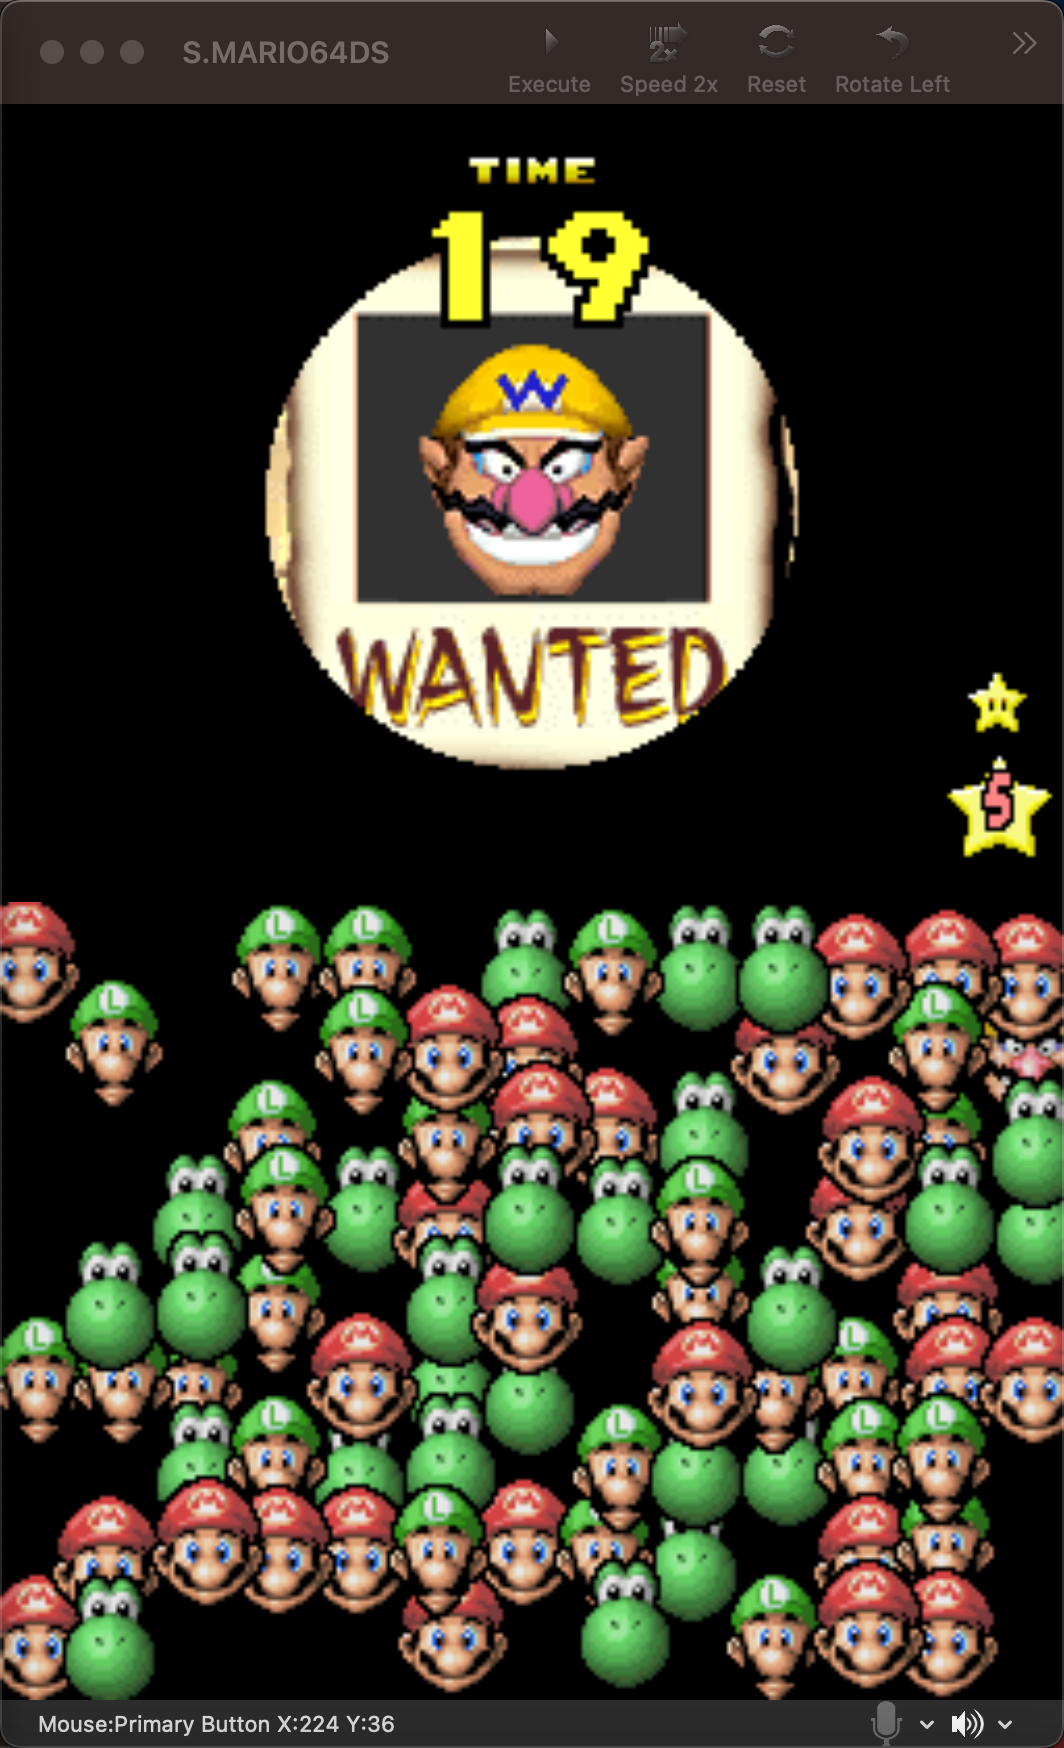

In [6]:
image

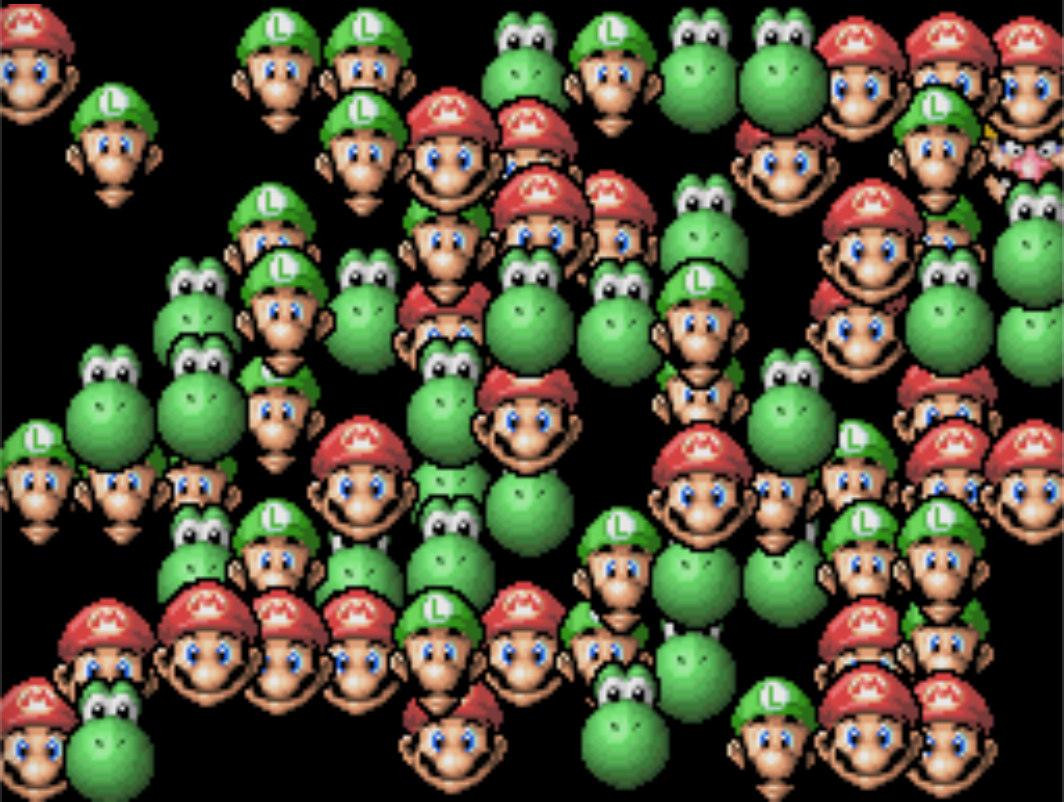

In [7]:
width, height = image.size

cropped_image = image.crop(
    box=(0, int((height + BOTTOM_BORDER_PIXELS) / 2), width, height - BOTTOM_BORDER_PIXELS),
)


cropped_image

In [8]:
character_to_find = get_character_to_search_for(image=image)

if character_to_find is None:
    print('No character detected yet!')


character_to_find

'wario'

In [20]:
results = model(cropped_image)

results_pandas = results.pandas().xyxy[0]

highest_confidence_box = 0
highest_confidence_boxes = results_pandas[results_pandas['name'] == character_to_find]

if len(highest_confidence_boxes) > 0:
    highest_confidence_box = highest_confidence_boxes.iloc[0]

# TODO: check confidence, assert it is high enough


highest_confidence_box

xmin           967.656067
ymin            86.777901
xmax          1063.861328
ymax            220.59613
confidence       0.975522
class                   2
name                wario
Name: 74, dtype: object

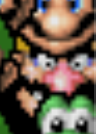

In [21]:
cropped_image.crop(
    box=(
        highest_confidence_box['xmin'],
        highest_confidence_box['ymin'],
        highest_confidence_box['xmax'],
        highest_confidence_box['ymax'],
    )
)

In [11]:
window_width = window['kCGWindowBounds']['Width']
window_height = window['kCGWindowBounds']['Height']
image_width, image_height = image.size

image_to_window_width_adjustment = window_width / image_width
image_to_window_height_adjustment = window_height / image_height


image_to_window_width_adjustment, image_to_window_height_adjustment

(0.5, 0.5)

In [12]:
x_mean = (highest_confidence_box['xmin'] + highest_confidence_box['xmax']) / 2
y_mean = (highest_confidence_box['ymin'] + highest_confidence_box['ymax']) / 2


x_mean, y_mean

(1015.7586975097656, 153.68701553344727)

In [13]:
mouse_move(
    x_position=(
        window['kCGWindowBounds']['X']  # window leftmost X-point
        + (x_mean * image_to_window_width_adjustment)  # bounding box X-point multiplied by image-to-window width adjustment value from PIL image to actual game window
    ),
    y_position=(
        window['kCGWindowBounds']['Y']  # window topmost Y-point
        + ((window_height + (BOTTOM_BORDER_PIXELS * image_to_window_height_adjustment)) / 2)  # adjust window height to match the top of the cropped area from above
        + (y_mean * image_to_window_height_adjustment)  # bounding box Y-point multiplied by image-to-window height adjustment value from PIL image to actual game window
    ),
)

----- 